#Aim: 
The Aim to this notebook is to create a fingerprint identification system using Socofing dataset.

In [66]:
from os import path
if not path.exists('utils.py'): # If running on colab: the first time download and unzip additional files
    !wget https://biolab.csr.unibo.it/samples/fr/files.zip
    !unzip files.zip

In [67]:
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from utils import *
from ipywidgets import interact

# Step 1: Fingerprint segmentation

First of all we load a fingerprint image: it will be stored in memory as a NumPy array.


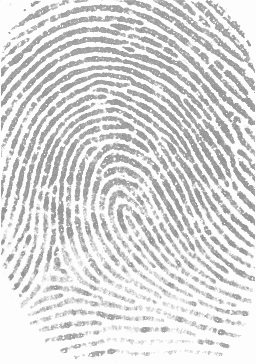

In [68]:
fingerprint = cv.imread('samples/sample_1_1.png', cv.IMREAD_GRAYSCALE)
show(fingerprint, f'Fingerprint with size (w,h): {fingerprint.shape[::-1]}')

# We want to the level 1 and level 2 features for this fingerprint

The segmentation step is aimed at separating the fingerprint area (foreground) from the background.
The foreground is characterized by the presence of a striped and oriented pattern; background presents a uniform pattern.   
We will use a very simple technique based on the magnitude of the local gradient.


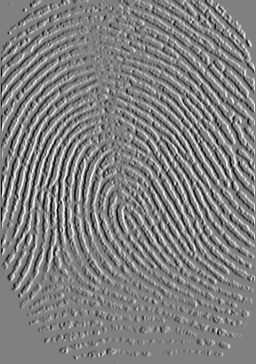
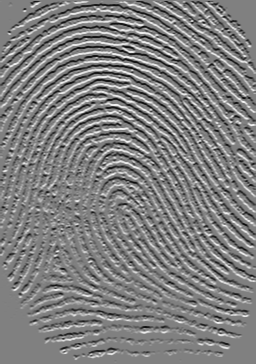

In [69]:
# Calculate the local gradient (using Sobel filters)
gx, gy = cv.Sobel(fingerprint, cv.CV_32F, 1, 0), cv.Sobel(fingerprint, cv.CV_32F, 0, 1)
show((gx, 'Gx'), (gy, 'Gy'))

# The Sobel method, or Sobel filter, is a gradient-based method that looks for strong changes in the first derivative of an image. The Sobel edge detector uses a pair of 3 × 3 convolution masks, one estimating the gradient in the x-direction and the other in the y-direction.


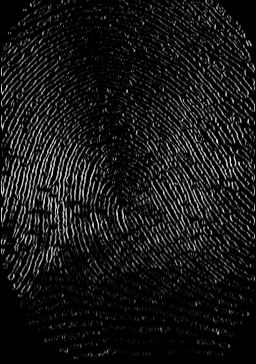
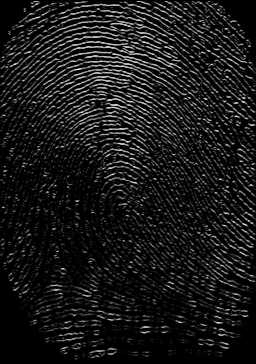
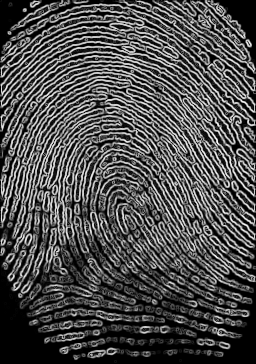

In [70]:
# Calculate the magnitude of the gradient for each pixel
gx2, gy2 = gx**2, gy**2
gm = np.sqrt(gx2 + gy2)
show((gx2, 'Gx**2'), (gy2, 'Gy**2'), (gm, 'Gradient magnitude'))

# The gradient magnitude is used to measure how strong the change in image intensity is. The gradient magnitude is a real-valued number that quantifies the “strength” of the change in intensity. The gradient orientation is used to determine in which direction the change in intensity is pointing


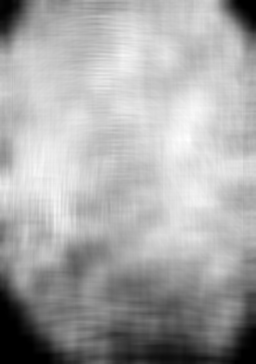

In [71]:
# Integral over a square window
sum_gm = cv.boxFilter(gm, -1, (25, 25), normalize = False)
show(sum_gm, 'Integral of the gradient magnitude')

# Sum over 25, 25 boxes 


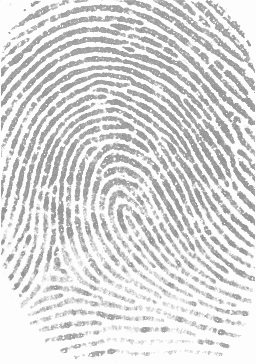
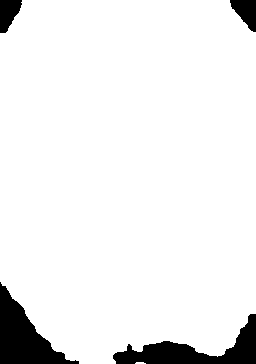
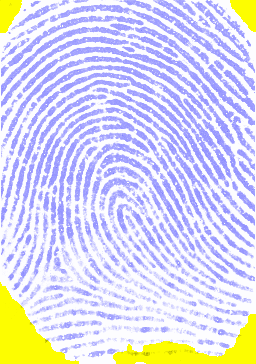

In [72]:
# Use a simple threshold for segmenting the fingerprint pattern
thr = sum_gm.max() * 0.2
mask = cv.threshold(sum_gm, thr, 255, cv.THRESH_BINARY)[1].astype(np.uint8)
show(fingerprint, mask, cv.merge((mask, fingerprint, fingerprint)))

# Step 2: Estimation of local ridge orientation

The local ridge orientation at $(j,i)$ is the angle $\theta_{j,i}\in[0,180°[$ that the fingerprint ridges form with the horizontal axis in an arbitrary small neighborhood centered in $(j,i)$.  
For each pixel, we will estimate the local orientation from the gradient $[Gx,Gy]$, which we already computed in the segmentation step (see *A.M. Bazen and S.H. Gerez, "Systematic methods for the computation of the directional fields and singular points of fingerprints," in IEEE tPAMI, July 2002*).  

The ridge orientation is estimated as ortoghonal to the gradient orientation, averaged over a window $W$.  

$G_{xx}=\sum_W{G_x^2}$, $G_{yy}=\sum_W{G_y^2}$, $G_{xy}=\sum_W{G_xG_y}$

$\theta=\frac{\pi}{2} + \frac{phase(G_{xx}-G_{yy}, 2G_{xy})}{2}$

For each orientation, we will also calculate a confidence value (strength), which measures how much all gradients in $W$ share the same orientation.  

$strength = \frac{\sqrt{(G_{xx}-G_{yy})^2+(2G_{xy})^2}}{G_{xx}+G_{yy}}$


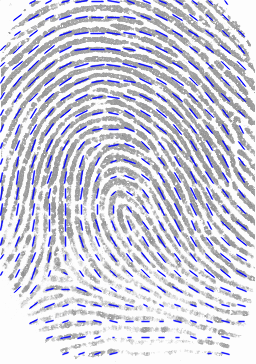

In [73]:
W = (23, 23)
gxx = cv.boxFilter(gx2, -1, W, normalize = False)
gyy = cv.boxFilter(gy2, -1, W, normalize = False)
gxy = cv.boxFilter(gx * gy, -1, W, normalize = False)
gxx_gyy = gxx - gyy
gxy2 = 2 * gxy

orientations = (cv.phase(gxx_gyy, -gxy2) + np.pi) / 2 # '-' to adjust for y axis direction
sum_gxx_gyy = gxx + gyy
strengths = np.divide(cv.sqrt((gxx_gyy**2 + gxy2**2)), sum_gxx_gyy, out=np.zeros_like(gxx), where=sum_gxx_gyy!=0)
show(draw_orientations(fingerprint, orientations, strengths, mask, 1, 16), 'Orientation image')

# Step 3: Estimation of local ridge frequency

The local ridge frequency $f_{j,i}$ at $(j,i)$ is the number of ridges per unit length along a hypothetical segment centered in $(j,i)$ and orthogonal to the local ridge orientation $\theta_{j,i}$.

For simplicity, we will assume a constant frequency over all the fingerprint and estimate its reciprocal (the ridge-line period) from a small region of the image.


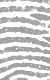

In [74]:
region = fingerprint[10:90,80:130]
show(region)

Then the *x-signature* is computed from the region and the ridge-line period is estimated as the average number of pixels between two consecutive peaks (see *L. Hong, Y. Wan and A. Jain, "Fingerprint image enhancement: algorithm and performance evaluation," in IEEE tPAMI, Aug. 1998*)

In [75]:
# before computing the x-signature, the region is smoothed to reduce noise
smoothed = cv.blur(region, (5,5), -1)
xs = np.sum(smoothed, 1) # the x-signature of the region
print(xs)

[10697 10796 11245 11970 12058 11508 10815 10064  9314  9125  9707 10389
 10912 11370 11564 11116 10419  9916  9532  9250  9370  9833 10348 10899
 11430 11429 11180 10773 10152  9409  9243  9351  9847 10620 11430 11482
 11147 10536  9791  9010  8966  9337  9845 10431 10986 11071 10877 10416
  9732  9264  9514  9946 10642 11353 11533 11050 10398  9649  9345  9636
 10183 10614 10849 10646 10197  9827  9762  9908 10237 10529 10628 10437
 10203 10011 10108 10364 10658 10828 10986 11106]


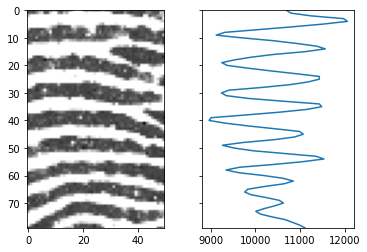

In [76]:
x = np.arange(region.shape[0])
f, axarr = plt.subplots(1,2, sharey = True)
axarr[0].imshow(region,cmap='gray')
axarr[1].plot(xs, x)
axarr[1].set_ylim(region.shape[0]-1,0)
plt.show()

In [77]:
# Find the indices of the x-signature local maxima
local_maxima = np.nonzero(np.r_[False, xs[1:] > xs[:-1]] & np.r_[xs[:-1] >= xs[1:], False])[0]

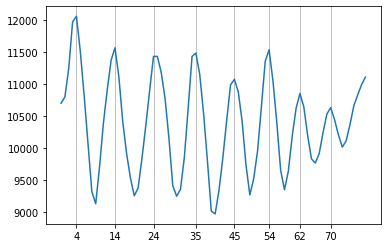

In [78]:
x = np.arange(region.shape[0])
plt.plot(x, xs)
plt.xticks(local_maxima)
plt.grid(True, axis='x')
plt.show()

In [79]:
# Calculate all the distances between consecutive peaks
distances = local_maxima[1:] - local_maxima[:-1]
print(distances)

[10 10 11 10  9  8  8]


In [80]:
# Estimate the ridge line period as the average of the above distances
ridge_period = np.average(distances)
print(ridge_period)

9.428571428571429


# Step 4: Fingerprint enhancement

In order to enhance the fingerprint pattern, we will perform a *contextual convolution* with a bank of Gabor filters.  
In this simple example we are using a constant ridge-line frequency, hence all the filters will have the same period and the only parameter will be the number of orientations (or_count).  
As it is a contextual convolution, a different filter should be applied to each pixel, according to the corresponding ridge-line orientation. Unfortunately this kind of operation is not available in OpenCV and implementing it in Python would be very inefficient; hence, we will apply all the filters to the whole image (that is, producing a filtered image for each filter) and then we will assemble the enhanced image taking the right pixel from each filtered image, using the discretized orientation indices as a lookup table.

In [81]:
# Create the filter bank
or_count = 8
gabor_bank = [gabor_kernel(ridge_period, o) for o in np.arange(0, np.pi, np.pi/or_count)]


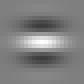
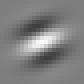
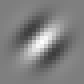
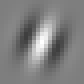
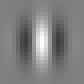
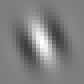
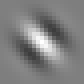
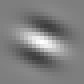

In [82]:
show(*gabor_bank)


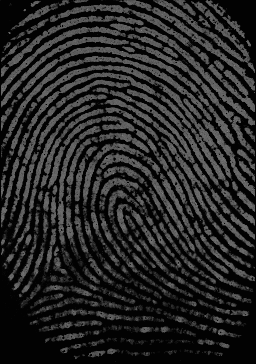
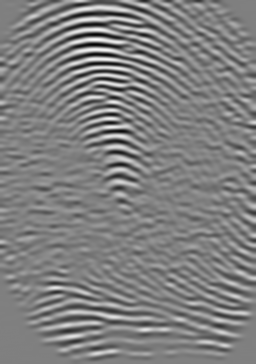
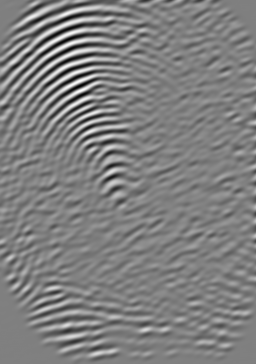
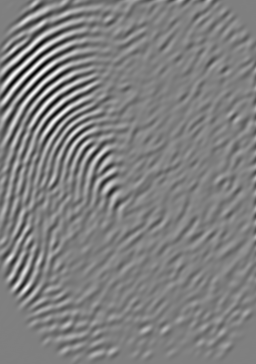
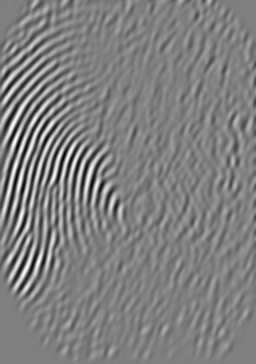
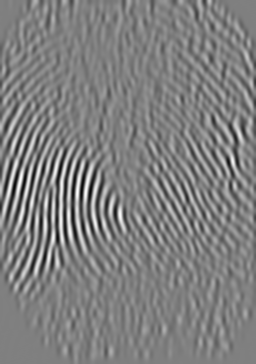
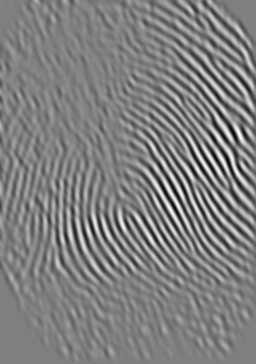
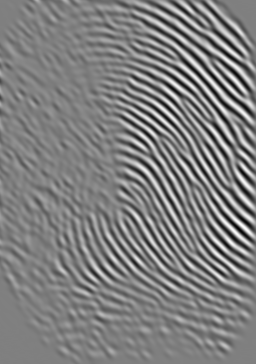
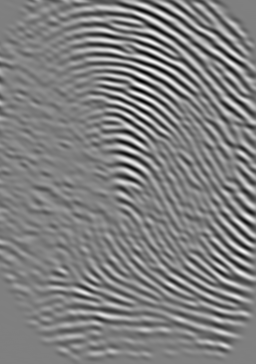

In [83]:
# Filter the whole image with each filter
# Note that the negative image is actually used, to have white ridges on a black background as a result
nf = 255-fingerprint
all_filtered = np.array([cv.filter2D(nf, cv.CV_32F, f) for f in gabor_bank])
show(nf, *all_filtered)


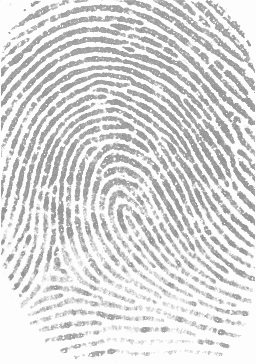
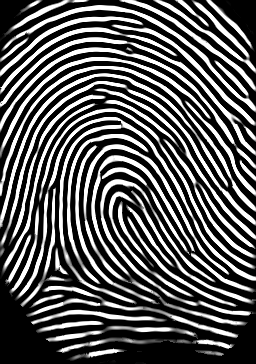

In [84]:
y_coords, x_coords = np.indices(fingerprint.shape)
# For each pixel, find the index of the closest orientation in the gabor bank
orientation_idx = np.round(((orientations % np.pi) / np.pi) * or_count).astype(np.int32) % or_count
# Take the corresponding convolution result for each pixel, to assemble the final result
filtered = all_filtered[orientation_idx, y_coords, x_coords]
# Convert to gray scale and apply the mask
enhanced = mask & np.clip(filtered, 0, 255).astype(np.uint8)
show(fingerprint, enhanced)

# Step 5: Detection of minutiae positions

In this simple example, minutiae will be detected from the *ridge line skeleton*, obtained by binarizing and thinning the enhanced ridge lines.


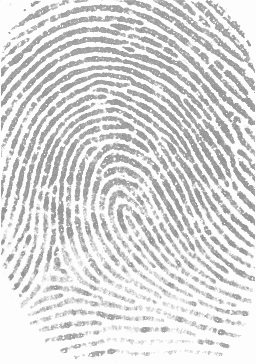
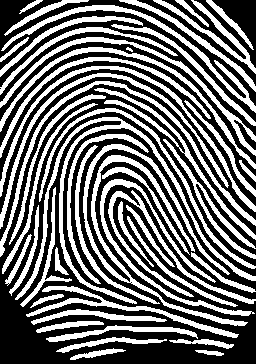
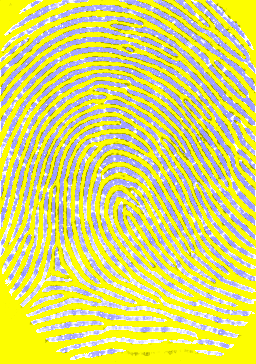

In [85]:
# Binarization
_, ridge_lines = cv.threshold(enhanced, 32, 255, cv.THRESH_BINARY)
show(fingerprint, ridge_lines, cv.merge((ridge_lines, fingerprint, fingerprint)))


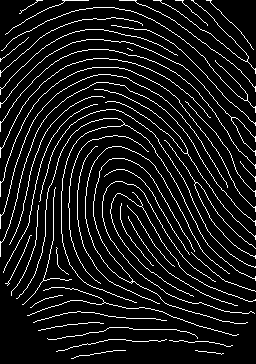
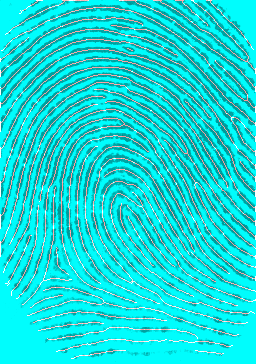

In [86]:
# Thinning
skeleton = cv.ximgproc.thinning(ridge_lines, thinningType = cv.ximgproc.THINNING_GUOHALL)
show(skeleton, cv.merge((fingerprint, fingerprint, skeleton)))

Then, for each pixel $p$ of the skeleton, the *crossing number* $cn(p)$ is computed as the number of transitions from black to white pixels in its 8-neighborhood

```
   v[0] v[1] v[2]
   v[7]   p  v[3]
   v[6] v[5] v[4]
```
$cn(v)=\sum_{i=0}^7\begin{cases} 1 & \mbox{if } v[i]<v[(i+1) \mod 8] \\ 0 & \mbox{otherwise} \end{cases}$

In [87]:
def compute_crossing_number(values):
    return np.count_nonzero(values < np.roll(values, -1))

To efficiently compute all the crossing numbers, a 3x3 filter is used to convert each possible 8-neighborhood into a byte value (by considering each pixel as a bit).  
Then a lookup table maps each byte value [0,255] into the corresponding crossing number.

In [88]:
# Create a filter that converts any 8-neighborhood into the corresponding byte value [0,255]
cn_filter = np.array([[  1,  2,  4],
                      [128,  0,  8],
                      [ 64, 32, 16]
                     ])

In [89]:
# Create a lookup table that maps each byte value to the corresponding crossing number
all_8_neighborhoods = [np.array([int(d) for d in f'{x:08b}'])[::-1] for x in range(256)]
cn_lut = np.array([compute_crossing_number(x) for x in all_8_neighborhoods]).astype(np.uint8)

In [90]:
# Skeleton: from 0/255 to 0/1 values
skeleton01 = np.where(skeleton!=0, 1, 0).astype(np.uint8)
# Apply the filter to encode the 8-neighborhood of each pixel into a byte [0,255]
cn_values = cv.filter2D(skeleton01, -1, cn_filter, borderType = cv.BORDER_CONSTANT)
# Apply the lookup table to obtain the crossing number of each pixel
cn = cv.LUT(cn_values, cn_lut)
# Keep only crossing numbers on the skeleton
cn[skeleton==0] = 0

The list of minutiae is finally obtained from the coordinates of pixels with crossing number 1 (terminations) or 3 (bifurcations).  
Each minutia is stored as a tuple $(x, y, t)$ where $t$ is $true$ for terminations.  
Note that, for now, we are not computing the minutiae *direction*, but only their location and type.

In [91]:
# crossing number == 1 --> Termination, crossing number == 3 --> Bifurcation
minutiae = [(x,y,cn[y,x]==1) for y, x in zip(*np.where(np.isin(cn, [1,3])))]


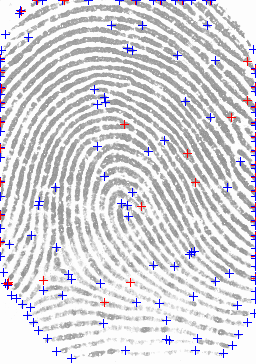
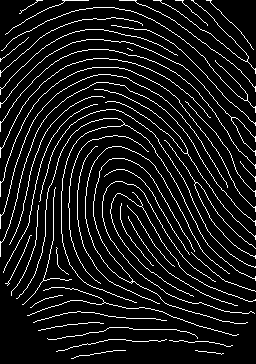
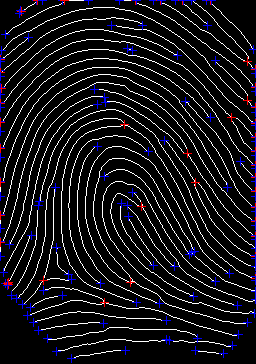

In [92]:
show(draw_minutiae(fingerprint, minutiae), skeleton, draw_minutiae(skeleton, minutiae))

From the above image we can note that near the borders of the pattern many false minutiae are detected: we can remove them by computing the *distance transform* of the segmentation mask and choosing a threshold so that minutiae too close to the mask border are excluded.


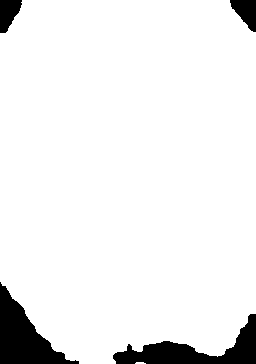
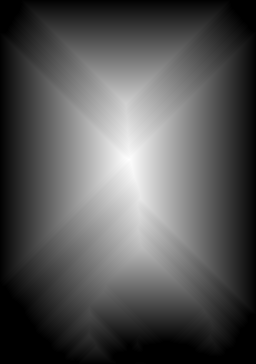

In [93]:
# A 1-pixel background border is added to the mask before computing the distance transform
mask_distance = cv.distanceTransform(cv.copyMakeBorder(mask, 1, 1, 1, 1, cv.BORDER_CONSTANT), cv.DIST_C, 3)[1:-1,1:-1]
show(mask, mask_distance)

In [94]:
filtered_minutiae = list(filter(lambda m: mask_distance[m[1], m[0]]>10, minutiae))


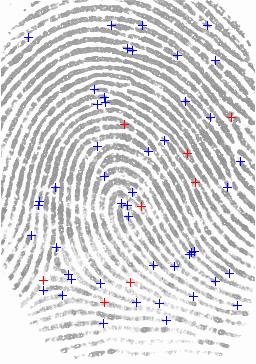
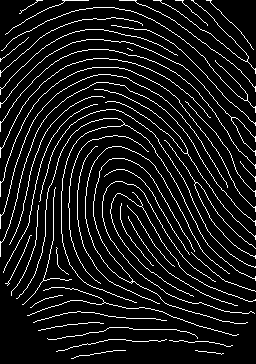
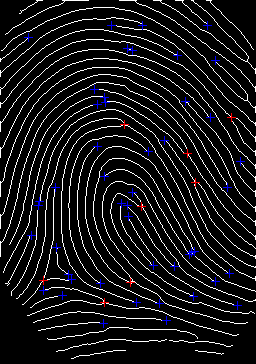

In [95]:
show(draw_minutiae(fingerprint, filtered_minutiae), skeleton, draw_minutiae(skeleton, filtered_minutiae))

# Step 6: Estimation of minutiae directions

The direction of a termination will be computed by following the ridge-line until another minutia is found or a distance of 20 pixels has been traveled.  
The direction of a bifurcation will be computed by considering the directions ($\theta_1$, $\theta_2$, $\theta_3$) of its three branches and calculating the mean of the two closest ones ($\theta_1$ and $\theta_2$ in the example below).  
Note that this is a simplified definition of minutiae direction, not completely consistent to the ISO standard minutiae-based template format, which is based on ridge and valley skeletons (see *ISO/IEC 19794-2, 2005*).

<img src="https://biolab.csr.unibo.it/samples/fr/images/min_directions.png">

In order to follow the ridge-line, for each position on the skeleton, the position of the next pixel to be visited must be determined. In the following, the eight possible direction of movement will be encoded as integer numbers in [0,7], following the same ordering previously used for the 8-neighborhood of a pixel $p$:

```
   0  1  2
   7  p  3
   6  5  4
```

The following function, given the previous direction of movement and the values of the 8 neighboring pixels, returns the  directions towards neighboring skeleton pixels, excluding the previously-visited one. A special value (8) indicates that there is no previous direction: it will be used at the first step.

In [96]:
def compute_next_ridge_following_directions(previous_direction, values):    
    next_positions = np.argwhere(values!=0).ravel().tolist()
    if len(next_positions) > 0 and previous_direction != 8:
        # There is a previous direction: return all the next directions, sorted according to the distance from it,
        #                                except the direction, if any, that corresponds to the previous position
        next_positions.sort(key = lambda d: 4 - abs(abs(d - previous_direction) - 4))
        if next_positions[-1] == (previous_direction + 4) % 8: # the direction of the previous position is the opposite one
            next_positions = next_positions[:-1] # removes it
    return next_positions

It is always a good idea to avoid unnecessary computations: the next cell prepares two look-up tables.

In [97]:
r2 = 2**0.5 # sqrt(2)

# The eight possible (x, y) offsets with each corresponding Euclidean distance
xy_steps = [(-1,-1,r2),( 0,-1,1),( 1,-1,r2),( 1, 0,1),( 1, 1,r2),( 0, 1,1),(-1, 1,r2),(-1, 0,1)]

# LUT: for each 8-neighborhood and each previous direction [0,8], 
#      where 8 means "none", provides the list of possible directions
nd_lut = [[compute_next_ridge_following_directions(pd, x) for pd in range(9)] for x in all_8_neighborhoods]

The next function follows the skeleton until another minutia is found or a distance of 20 pixels has been traveled. If a minimum length of 10 pixels has been reached, it returns the corresponding angle, otherwise it returns None.

In [98]:
def follow_ridge_and_compute_angle(x, y, d = 8):
    px, py = x, y
    length = 0.0
    while length < 20: # max length followed
        next_directions = nd_lut[cn_values[py,px]][d]
        if len(next_directions) == 0:
            break
        # Need to check ALL possible next directions
        if (any(cn[py + xy_steps[nd][1], px + xy_steps[nd][0]] != 2 for nd in next_directions)):
            break # another minutia found: we stop here
        # Only the first direction has to be followed
        d = next_directions[0]
        ox, oy, l = xy_steps[d]
        px += ox ; py += oy ; length += l
    # check if the minimum length for a valid direction has been reached
    return math.atan2(-py+y, px-x) if length >= 10 else None

Finally, the cell below estimates all minutiae directions:
- in case of a termination, it simply calls the previous function,
- in case of a bifurcation, it follows the three branches and if all the three angles are valid, it computes the mean of the two closest ones.

The list of minutiae is finally obtained, with each minutia stored as a tuple $(x, y, t, d)$ where $t$ is $true$ for terminations and $d$ is the minutia direction in radians.

In [99]:
valid_minutiae = []
for x, y, term in filtered_minutiae:
    d = None
    if term: # termination: simply follow and compute the direction        
        d = follow_ridge_and_compute_angle(x, y)
    else: # bifurcation: follow each of the three branches
        dirs = nd_lut[cn_values[y,x]][8] # 8 means: no previous direction
        if len(dirs)==3: # only if there are exactly three branches
            angles = [follow_ridge_and_compute_angle(x+xy_steps[d][0], y+xy_steps[d][1], d) for d in dirs]
            if all(a is not None for a in angles):
                a1, a2 = min(((angles[i], angles[(i+1)%3]) for i in range(3)), key=lambda t: angle_abs_difference(t[0], t[1]))
                d = angle_mean(a1, a2)                
    if d is not None:
        valid_minutiae.append( (x, y, term, d) )


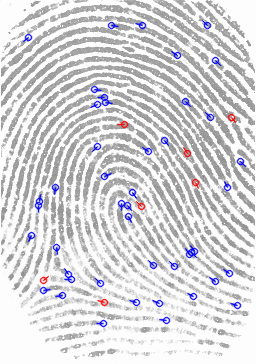

In [100]:
show(draw_minutiae(fingerprint, valid_minutiae))

# Step 7: Creation of local structures

In this section, starting from minutiae positions and directions, we will create local structures invariant for translation and rotation, which can be used for comparing fingerprints without a pre-alignment step.  
We will use a simplified version of Minutia Cylinder-Code (MCC, see *Minutia Cylinder-Code: a new representation and matching technique for fingerprint recognition", IEEE tPAMI 2010*): while MCC local structures can be represented as 3D structures (cylinders), where the base encodes spatial relationships between minutiae and the height directional relationships, here we will consider only the base of the cylinders, which is rotated according to the minutia direction and discretized into a fixed number of cells.

<img src="https://biolab.csr.unibo.it/samples/fr/images/simple_mcc.png">


In [101]:
# Compute the cell coordinates of a generic local structure
mcc_radius = 70
mcc_size = 16

g = 2 * mcc_radius / mcc_size
x = np.arange(mcc_size)*g - (mcc_size/2)*g + g/2
y = x[..., np.newaxis]
iy, ix = np.nonzero(x**2 + y**2 <= mcc_radius**2)
ref_cell_coords = np.column_stack((x[ix], x[iy]))

In [102]:
mcc_sigma_s = 7.0
mcc_tau_psi = 400.0
mcc_mu_psi = 1e-2

def Gs(t_sqr):
    """Gaussian function with zero mean and mcc_sigma_s standard deviation, see eq. (7) in MCC paper"""
    return np.exp(-0.5 * t_sqr / (mcc_sigma_s**2)) / (math.tau**0.5 * mcc_sigma_s)

def Psi(v):
    """Sigmoid function that limits the contribution of dense minutiae clusters, see eq. (4)-(5) in MCC paper"""
    return 1. / (1. + np.exp(-mcc_tau_psi * (v - mcc_mu_psi)))

In [103]:
# n: number of minutiae
# c: number of cells in a local structure

xyd = np.array([(x,y,d) for x,y,_,d in valid_minutiae]) # matrix with all minutiae coordinates and directions (n x 3)

# rot: n x 2 x 2 (rotation matrix for each minutia)
d_cos, d_sin = np.cos(xyd[:,2]).reshape((-1,1,1)), np.sin(xyd[:,2]).reshape((-1,1,1))
rot = np.block([[d_cos, d_sin], [-d_sin, d_cos]])

# rot@ref_cell_coords.T : n x 2 x c
# xy : n x 2
xy = xyd[:,:2]
# cell_coords: n x c x 2 (cell coordinates for each local structure)
cell_coords = np.transpose(rot@ref_cell_coords.T + xy[:,:,np.newaxis],[0,2,1])

# cell_coords[:,:,np.newaxis,:]      :  n x c  x 1 x 2
# xy                                 : (1 x 1) x n x 2
# cell_coords[:,:,np.newaxis,:] - xy :  n x c  x n x 2
# dists: n x c x n (for each cell of each local structure, the distance from all minutiae)
dists = np.sum((cell_coords[:,:,np.newaxis,:] - xy)**2, -1)

# cs : n x c x n (the spatial contribution of each minutia to each cell of each local structure)
cs = Gs(dists)
diag_indices = np.arange(cs.shape[0])
cs[diag_indices,:,diag_indices] = 0 # remove the contribution of each minutia to its own cells

# local_structures : n x c (cell values for each local structure)
local_structures = Psi(np.sum(cs, -1))

In [104]:
@interact(i=(0,len(valid_minutiae)-1))
def test(i=0):
    show(draw_minutiae_and_cylinder(fingerprint, ref_cell_coords, valid_minutiae, local_structures, i))

interactive(children=(IntSlider(value=0, description='i', max=51), Output()), _dom_classes=('widget-interact',…

# Step 8: Fingerprint comparison

We started from an image (*fingerprint*), obtained a list of minutiae (*valid_minutiae*) and their corresponding local structures (matrix *local_structures* with a row for each minutia):

In [105]:
print(f"""Fingerprint image: {fingerprint.shape[1]}x{fingerprint.shape[0]} pixels
Minutiae: {len(valid_minutiae)}
Local structures: {local_structures.shape}""")

Fingerprint image: 256x364 pixels
Minutiae: 52
Local structures: (52, 208)


In the following we will more concisely name them f1, m1, ls1:

In [106]:
f1, m1, ls1 = fingerprint, valid_minutiae, local_structures

Then we will load analogous data of another fingerprint: f2, m2, ls2

In [107]:
ofn = 'samples/sample_1_2' # Fingerprint of the same finger
#ofn = 'samples/sample_2' # Fingerprint of a different finger
f2, (m2, ls2) = cv.imread(f'{ofn}.png', cv.IMREAD_GRAYSCALE), np.load(f'{ofn}.npz', allow_pickle=True).values()

The similarity between two local structures $r_1$ and $r_2$ can be simply computed as one minus their normalized Euclidean distance:

$similarity(r_1, r_2) = 1 - \frac {\| r_1 - r_2 \|}{\|r_1\| + \|r_2\|}$

The following cell computes the matrix of all normalized Euclidean distances between local structures in ls1 and ls2.

In [108]:
# Compute all pairwise normalized Euclidean distances between local structures in v1 and v2
# ls1                       : n1 x  c
# ls1[:,np.newaxis,:]       : n1 x  1 x c
# ls2                       : (1 x) n2 x c
# ls1[:,np.newaxis,:] - ls2 : n1 x  n2 x c 
# dists                     : n1 x  n2
dists = np.sqrt(np.sum((ls1[:,np.newaxis,:] - ls2)**2, -1))
dists /= (np.sqrt(np.sum(ls1**2, 1))[:,np.newaxis] + np.sqrt(np.sum(ls2**2, 1))) # Normalize as in eq. (17) of MCC paper

In the next cell, we finally compare the two fingerprints by using the Local Similarity Sort (LSS) technique (see eq. 23 in the MCC paper), which simply selects the num_p highest similarities (i.e. the smallest distances) and compute the comparison *score* as their average. The indices of the corresponding minutia pairs are stored in *pairs*, and used in the last cell to show the result.

In [109]:
# Select the num_p pairs with the smallest distances (LSS technique)
num_p = 5 # For simplicity: a fixed number of pairs
pairs = np.unravel_index(np.argpartition(dists, num_p, None)[:num_p], dists.shape)
score = 1 - np.mean(dists[pairs[0], pairs[1]]) # See eq. (23) in MCC paper
print(f'Comparison score: {score:.2f}')

Comparison score: 0.78


In [110]:
@interact(i = (0,len(pairs[0])-1), show_local_structures = False)
def show_pairs(i=0, show_local_structures = False):
    show(draw_match_pairs(f1, m1, ls1, f2, m2, ls2, ref_cell_coords, pairs, i, show_local_structures))

interactive(children=(IntSlider(value=0, description='i', max=4), Checkbox(value=False, description='show_loca…

# Step - 9: Apply on a new dataset

In [111]:
! pip install -q kaggle

In [112]:
from google.colab import files

In [113]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [114]:
! cp kaggle.json ~/.kaggle/

In [115]:
! chmod 600 ~/.kaggle/kaggle.json

In [116]:
!chmod 600 ~/.kaggle/kaggle.json

In [117]:
!kaggle datasets list

ref                                                        title                                       size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide       Covid Cases and Deaths WorldWide             8KB  2023-02-01 12:22:51           3498         91  1.0              
datascientistanna/customers-dataset                        Shop Customer Data                          23KB  2023-02-07 18:42:21           2523         70  1.0              
rajugc/imdb-top-250-movies-dataset                         IMDB Top 250 Movies Dataset                 52KB  2023-02-11 16:02:01            941         38  1.0              
ahsan81/hotel-reservations-classification-dataset          Hotel Reservations Dataset                 480KB  2023-01-04 12:50:31  

In [118]:
!kaggle datasets download -d ruizgara/socofing

socofing.zip: Skipping, found more recently modified local copy (use --force to force download)


In [119]:
!unzip /content/socofing.zip

Archive:  /content/socofing.zip
replace SOCOFing/Altered/Altered-Easy/100__M_Left_index_finger_CR.BMP? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Step 10: Making a pipeline

In [120]:
def ImagePipeline(image):
    # Step 1: 

    # Read the Image
    fingerprint = cv.imread(image, cv.IMREAD_GRAYSCALE)
    # show(fingerprint, f'Fingerprint with size (w,h): {fingerprint.shape[::-1]}')

    # Calculate the local gradient (using Sobel filters)
    gx, gy = cv.Sobel(fingerprint, cv.CV_32F, 1, 0), cv.Sobel(fingerprint, cv.CV_32F, 0, 1)
    # show((gx, 'Gx'), (gy, 'Gy'))

    # Calculate the magnitude of the gradient for each pixel
    gx2, gy2 = gx**2, gy**2
    gm = np.sqrt(gx2 + gy2)
    # show((gx2, 'Gx**2'), (gy2, 'Gy**2'), (gm, 'Gradient magnitude'))

    # Integral over a square window
    sum_gm = cv.boxFilter(gm, -1, (5,5), normalize = False)
    # show(sum_gm, 'Integral of the gradient magnitude')

    # Use a simple threshold for segmenting the fingerprint pattern
    thr = sum_gm.max() * 0.2
    mask = cv.threshold(sum_gm, thr, 255, cv.THRESH_BINARY)[1].astype(np.uint8)
    # show(fingerprint, mask, cv.merge((mask, fingerprint, fingerprint)))


    
    # ------------------------------------------------------------------------


    
    # Step 2: 

    W = (5,5)
    gxx = cv.boxFilter(gx2, -1, W, normalize = False)
    gyy = cv.boxFilter(gy2, -1, W, normalize = False)
    gxy = cv.boxFilter(gx * gy, -1, W, normalize = False)
    gxx_gyy = gxx - gyy
    gxy2 = 2 * gxy

    orientations = (cv.phase(gxx_gyy, -gxy2) + np.pi) / 2 # '-' to adjust for y axis direction
    sum_gxx_gyy = gxx + gyy
    strengths = np.divide(cv.sqrt((gxx_gyy**2 + gxy2**2)), sum_gxx_gyy, out=np.zeros_like(gxx), where=sum_gxx_gyy!=0)
    # print("Ridge Orientations: ")
    # show(draw_orientations(fingerprint, orientations, strengths, mask, 5,4), 'Orientation image')

    
    # ------------------------------------------------------------------------


    # Step 3: 

    # print('Finding Ridge Frequency: ')

    region = fingerprint[10:40,50:60]
    # show(region)

    # before computing the x-signature, the region is smoothed to reduce noise
    smoothed = cv.blur(region, (2,2), -1)
    xs = np.sum(smoothed, 1) # the x-signature of the region
    # print(xs)

    x = np.arange(region.shape[0])
    # f, axarr = plt.subplots(1,2, sharey = True)
    # axarr[0].imshow(region,cmap='gray')
    # axarr[1].plot(xs, x)
    # axarr[1].set_ylim(region.shape[0]-1,0)
    # plt.show()

    # Find the indices of the x-signature local maxima
    local_maxima = np.nonzero(np.r_[False, xs[1:] > xs[:-1]] & np.r_[xs[:-1] >= xs[1:], False])[0]

    x = np.arange(region.shape[0])
    # plt.plot(x, xs)
    # plt.xticks(local_maxima)
    # plt.grid(True, axis='x')
    # plt.show()

    # Calculate all the distances between consecutive peaks
    distances = local_maxima[1:] - local_maxima[:-1]
    # print(distances)

    # Estimate the ridge line period as the average of the above distances
    ridge_period = np.average(distances)
    # print(ridge_period) 
    

    # ------------------------------------------------------------------------


    # Step 4: Fingerprint Enhancement

    # print("Image Enhancement: ")
    
    # Create the filter bank
    or_count = 8
    gabor_bank = [gabor_kernel(ridge_period, o) for o in np.arange(0, np.pi, np.pi/or_count)]

    # show(*gabor_bank)

    # Filter the whole image with each filter
    # Note that the negative image is actually used, to have white ridges on a black background as a result
    nf = 255-fingerprint
    all_filtered = np.array([cv.filter2D(nf, cv.CV_32F, f) for f in gabor_bank])
    # show(nf, *all_filtered)

    y_coords, x_coords = np.indices(fingerprint.shape)
    # For each pixel, find the index of the closest orientation in the gabor bank
    orientation_idx = np.round(((orientations % np.pi) / np.pi) * or_count).astype(np.int32) % or_count
    # Take the corresponding convolution result for each pixel, to assemble the final result
    filtered = all_filtered[orientation_idx, y_coords, x_coords]
    # Convert to gray scale and apply the mask
    enhanced = mask & np.clip(filtered, 0, 255).astype(np.uint8)
    # show(fingerprint, enhanced)

    
    # ------------------------------------------------------------------------



    # Step 5: Find Minutiae Points

    # print("Find Minutiae Points: ")

    # Binarization
    _, ridge_lines = cv.threshold(enhanced, 32, 255, cv.THRESH_BINARY)
    # show(fingerprint, ridge_lines, cv.merge((ridge_lines, fingerprint, fingerprint)))


    # Thinning
    skeleton = cv.ximgproc.thinning(ridge_lines, thinningType = cv.ximgproc.THINNING_GUOHALL)
    # show(skeleton, cv.merge((fingerprint, fingerprint, skeleton)))


    def compute_crossing_number(values):
        return np.count_nonzero(values < np.roll(values, -1))

    # Create a filter that converts any 8-neighborhood into the corresponding byte value [0,255]
    cn_filter = np.array([[  1,  2,  4],
                        [128,  0,  8],
                        [ 64, 32, 16]
                        ])
    
    # Create a lookup table that maps each byte value to the corresponding crossing number
    all_8_neighborhoods = [np.array([int(d) for d in f'{x:08b}'])[::-1] for x in range(256)]
    cn_lut = np.array([compute_crossing_number(x) for x in all_8_neighborhoods]).astype(np.uint8)

    # Skeleton: from 0/255 to 0/1 values
    skeleton01 = np.where(skeleton!=0, 1, 0).astype(np.uint8)
    # Apply the filter to encode the 8-neighborhood of each pixel into a byte [0,255]
    cn_values = cv.filter2D(skeleton01, -1, cn_filter, borderType = cv.BORDER_CONSTANT)
    # Apply the lookup table to obtain the crossing number of each pixel
    cn = cv.LUT(cn_values, cn_lut)
    # Keep only crossing numbers on the skeleton
    cn[skeleton==0] = 0    

    # crossing number == 1 --> Termination, crossing number == 3 --> Bifurcation
    minutiae = [(x,y,cn[y,x]==1) for y, x in zip(*np.where(np.isin(cn, [1,3])))]

    # show(draw_minutiae(fingerprint, minutiae), skeleton, draw_minutiae(skeleton, minutiae))

    # A 1-pixel background border is added to the mask before computing the distance transform
    mask_distance = cv.distanceTransform(cv.copyMakeBorder(mask, 1, 1, 1, 1, cv.BORDER_CONSTANT), cv.DIST_C, 3)[1:-1,1:-1]
    # show(mask, mask_distance)

    filtered_minutiae = list(filter(lambda m: mask_distance[m[1], m[0]]>10, minutiae))

    # show(draw_minutiae(fingerprint, filtered_minutiae), skeleton, draw_minutiae(skeleton, filtered_minutiae))


    
    # ------------------------------------------------------------------------



    # Step 6: Estimation of Minutiae Directions

    def compute_next_ridge_following_directions(previous_direction, values):    
        next_positions = np.argwhere(values!=0).ravel().tolist()
        if len(next_positions) > 0 and previous_direction != 8:
            # There is a previous direction: return all the next directions, sorted according to the distance from it,
            #                                except the direction, if any, that corresponds to the previous position
            next_positions.sort(key = lambda d: 4 - abs(abs(d - previous_direction) - 4))
            if next_positions[-1] == (previous_direction + 4) % 8: # the direction of the previous position is the opposite one
                next_positions = next_positions[:-1] # removes it
        return next_positions

    r2 = 2**0.5 # sqrt(2)

    # The eight possible (x, y) offsets with each corresponding Euclidean distance
    xy_steps = [(-1,-1,r2),( 0,-1,1),( 1,-1,r2),( 1, 0,1),( 1, 1,r2),( 0, 1,1),(-1, 1,r2),(-1, 0,1)]

    # LUT: for each 8-neighborhood and each previous direction [0,8], 
    #      where 8 means "none", provides the list of possible directions
    nd_lut = [[compute_next_ridge_following_directions(pd, x) for pd in range(9)] for x in all_8_neighborhoods]

    def follow_ridge_and_compute_angle(x, y, d = 8):
        px, py = x, y
        length = 0.0
        while length < 20: # max length followed
            next_directions = nd_lut[cn_values[py,px]][d]
            if len(next_directions) == 0:
                break
            # Need to check ALL possible next directions
            if (any(cn[py + xy_steps[nd][1], px + xy_steps[nd][0]] != 2 for nd in next_directions)):
                break # another minutia found: we stop here
            # Only the first direction has to be followed
            d = next_directions[0]
            ox, oy, l = xy_steps[d]
            px += ox ; py += oy ; length += l
        # check if the minimum length for a valid direction has been reached
        return math.atan2(-py+y, px-x) if length >= 10 else None

    valid_minutiae = []
    for x, y, term in filtered_minutiae:
        d = None
        if term: # termination: simply follow and compute the direction        
            d = follow_ridge_and_compute_angle(x, y)
        else: # bifurcation: follow each of the three branches
            dirs = nd_lut[cn_values[y,x]][8] # 8 means: no previous direction
            if len(dirs)==3: # only if there are exactly three branches
                angles = [follow_ridge_and_compute_angle(x+xy_steps[d][0], y+xy_steps[d][1], d) for d in dirs]
                if all(a is not None for a in angles):
                    a1, a2 = min(((angles[i], angles[(i+1)%3]) for i in range(3)), key=lambda t: angle_abs_difference(t[0], t[1]))
                    d = angle_mean(a1, a2)                
        if d is not None:
            valid_minutiae.append( (x, y, term, d) )

    # show(draw_minutiae(fingerprint, valid_minutiae))



    
    # ------------------------------------------------------------------------



    # Step 7: Compute Local Structures


    # Compute the cell coordinates of a generic local structure
    mcc_radius = 70
    mcc_size = 16

    g = 2 * mcc_radius / mcc_size
    x = np.arange(mcc_size)*g - (mcc_size/2)*g + g/2
    y = x[..., np.newaxis]
    iy, ix = np.nonzero(x**2 + y**2 <= mcc_radius**2)
    ref_cell_coords = np.column_stack((x[ix], x[iy]))

    mcc_sigma_s = 7.0
    mcc_tau_psi = 400.0
    mcc_mu_psi = 1e-2

    def Gs(t_sqr):
        """Gaussian function with zero mean and mcc_sigma_s standard deviation, see eq. (7) in MCC paper"""
        return np.exp(-0.5 * t_sqr / (mcc_sigma_s**2)) / (math.tau**0.5 * mcc_sigma_s)

    def Psi(v):
        """Sigmoid function that limits the contribution of dense minutiae clusters, see eq. (4)-(5) in MCC paper"""
        return 1. / (1. + np.exp(-mcc_tau_psi * (v - mcc_mu_psi)))


    # n: number of minutiae
    # c: number of cells in a local structure

    xyd = np.array([(x,y,d) for x,y,_,d in valid_minutiae]) # matrix with all minutiae coordinates and directions (n x 3)

    # rot: n x 2 x 2 (rotation matrix for each minutia)
    d_cos, d_sin = np.cos(xyd[:,2]).reshape((-1,1,1)), np.sin(xyd[:,2]).reshape((-1,1,1))
    rot = np.block([[d_cos, d_sin], [-d_sin, d_cos]])

    # rot@ref_cell_coords.T : n x 2 x c
    # xy : n x 2
    xy = xyd[:,:2]
    # cell_coords: n x c x 2 (cell coordinates for each local structure)
    cell_coords = np.transpose(rot@ref_cell_coords.T + xy[:,:,np.newaxis],[0,2,1])

    # cell_coords[:,:,np.newaxis,:]      :  n x c  x 1 x 2
    # xy                                 : (1 x 1) x n x 2
    # cell_coords[:,:,np.newaxis,:] - xy :  n x c  x n x 2
    # dists: n x c x n (for each cell of each local structure, the distance from all minutiae)
    dists = np.sum((cell_coords[:,:,np.newaxis,:] - xy)**2, -1)

    # cs : n x c x n (the spatial contribution of each minutia to each cell of each local structure)
    cs = Gs(dists)
    diag_indices = np.arange(cs.shape[0])
    cs[diag_indices,:,diag_indices] = 0 # remove the contribution of each minutia to its own cells

    # local_structures : n x c (cell values for each local structure)
    local_structures = Psi(np.sum(cs, -1))


    # @interact(i=(0,len(valid_minutiae)-1))
    # def test(i=0):
        # show(draw_minutiae_and_cylinder(fingerprint, ref_cell_coords, valid_minutiae, local_structures, i))


    
    # ------------------------------------------------------------------------



    # Step 8: Comparing Fingerprints

    # print(f"""Fingerprint image: {fingerprint.shape[1]}x{fingerprint.shape[0]} pixels
    # Minutiae: {len(valid_minutiae)}
    # Local structures: {local_structures.shape}""")

    f1, m1, ls1 = fingerprint, valid_minutiae, local_structures
    return f1, m1, ls1
        












In [121]:
f1, m1, ls1 = ImagePipeline('/content/socofing/SOCOFing/Real/100__M_Left_index_finger.BMP')

In [122]:
f2, m2, ls2 = ImagePipeline('/content/socofing/SOCOFing/Altered/Altered-Easy/103__F_Right_thumb_finger_Zcut.BMP')

In [123]:
# Compute all pairwise normalized Euclidean distances between local structures in v1 and v2
# ls1                       : n1 x  c
# ls1[:,np.newaxis,:]       : n1 x  1 x c
# ls2                       : (1 x) n2 x c
# ls1[:,np.newaxis,:] - ls2 : n1 x  n2 x c 
# dists                     : n1 x  n2
dists = np.sqrt(np.sum((ls1[:,np.newaxis,:] - ls2)**2, -1))
dists /= (np.sqrt(np.sum(ls1**2, 1))[:,np.newaxis] + np.sqrt(np.sum(ls2**2, 1))) # Normalize as in eq. (17) of MCC paper

In the next cell, we finally compare the two fingerprints by using the Local Similarity Sort (LSS) technique (see eq. 23 in the MCC paper), which simply selects the num_p highest similarities (i.e. the smallest distances) and compute the comparison *score* as their average. The indices of the corresponding minutia pairs are stored in *pairs*, and used in the last cell to show the result.

In [124]:
# Select the num_p pairs with the smallest distances (LSS technique)
num_p = 5 # For simplicity: a fixed number of pairs
pairs = np.unravel_index(np.argpartition(dists, num_p, None)[:num_p], dists.shape)
score = 1 - np.mean(dists[pairs[0], pairs[1]]) # See eq. (23) in MCC paper
print(f'Comparison score: {score:.2f}')

Comparison score: 0.47


In [125]:
@interact(i = (0,len(pairs[0])-1), show_local_structures = False)
def show_pairs(i=0, show_local_structures = False):
    show(draw_match_pairs(f1, m1, ls1, f2, m2, ls2, ref_cell_coords, pairs, i, show_local_structures))

interactive(children=(IntSlider(value=0, description='i', max=4), Checkbox(value=False, description='show_loca…

In [126]:
def comparison(f1, m1, ls1, path2):
    try:
        f2, m2, ls2 = ImagePipeline(path2)
    except: 
        return 0

    dists = np.sqrt(np.sum((ls1[:,np.newaxis,:] - ls2)**2, -1))
    dists /= (np.sqrt(np.sum(ls1**2, 1))[:,np.newaxis] + np.sqrt(np.sum(ls2**2, 1)))

    # Select the num_p pairs with the smallest distances (LSS technique)
    num_p = 5 # For simplicity: a fixed number of pairs
    pairs = np.unravel_index(np.argpartition(dists, num_p, None)[:num_p], dists.shape)
    score = 1 - np.mean(dists[pairs[0], pairs[1]]) # See eq. (23) in MCC paper
    print(f'Comparison score: {score:.2f}') 

    # @interact(i = (0,len(pairs[0])-1), show_local_structures = False)
    # def show_pairs(i=0, show_local_structures = False):
    #     show(draw_match_pairs(f1, m1, ls1, f2, m2, ls2, ref_cell_coords, pairs, i, show_local_structures)) 

    return score

In [127]:

# Taking a Altered Fingerprint and comparing to all real fingerprints
# Trying to find the best Match
import os

def Check(path): 

    path1 = path

    best_score = 0

    best_match = 'None'

    f1, m1, ls1 = ImagePipeline(path1)

    folder_path = "/content/socofing/SOCOFing/Real/"

    for filename in os.listdir(folder_path):
        temp = folder_path+str(filename)
        print(temp)
        try: 
            score = comparison(f1, m1, ls1, temp)
            # print(score)
            if score > best_score:
                best_score = score
                best_match = filename
        except: 
            print('gave error - corrupt image')
            


    print(best_score, best_match)



In [128]:
Check('/content/socofing/SOCOFing/Real/132__M_Right_thumb_finger.BMP')

/content/socofing/SOCOFing/Real/179__M_Left_index_finger.BMP
Comparison score: 0.56
/content/socofing/SOCOFing/Real/298__M_Left_index_finger.BMP
Comparison score: 0.61
/content/socofing/SOCOFing/Real/397__M_Left_ring_finger.BMP
Comparison score: 0.30
/content/socofing/SOCOFing/Real/265__M_Right_ring_finger.BMP
Comparison score: 0.59
/content/socofing/SOCOFing/Real/299__M_Left_middle_finger.BMP
Comparison score: 0.30
/content/socofing/SOCOFing/Real/163__M_Right_little_finger.BMP
/content/socofing/SOCOFing/Real/558__M_Right_ring_finger.BMP
Comparison score: 0.05
/content/socofing/SOCOFing/Real/393__M_Right_middle_finger.BMP
Comparison score: 0.52
/content/socofing/SOCOFing/Real/344__M_Right_ring_finger.BMP
/content/socofing/SOCOFing/Real/484__M_Right_little_finger.BMP
Comparison score: 0.49
/content/socofing/SOCOFing/Real/223__M_Right_thumb_finger.BMP
Comparison score: 0.80
/content/socofing/SOCOFing/Real/493__M_Right_index_finger.BMP


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Streaming output truncated to the last 5000 lines.
/content/socofing/SOCOFing/Real/363__M_Right_ring_finger.BMP
Comparison score: 0.64
/content/socofing/SOCOFing/Real/212__M_Right_thumb_finger.BMP
/content/socofing/SOCOFing/Real/345__M_Right_ring_finger.BMP
Comparison score: 0.48
/content/socofing/SOCOFing/Real/454__M_Right_little_finger.BMP
/content/socofing/SOCOFing/Real/509__M_Left_middle_finger.BMP
/content/socofing/SOCOFing/Real/585__M_Right_thumb_finger.BMP
Comparison score: 0.53
/content/socofing/SOCOFing/Real/193__M_Left_index_finger.BMP
Comparison score: 0.67
/content/socofing/SOCOFing/Real/293__F_Right_middle_finger.BMP
Comparison score: 0.47
/content/socofing/SOCOFing/Real/227__M_Right_ring_finger.BMP
Comparison score: 0.63
/content/socofing/SOCOFing/Real/545__M_Right_middle_finger.BMP
/content/socofing/SOCOFing/Real/419__F_Right_ring_finger.BMP
Comparison score: 0.78
/content/socofing/SOCOFing/Real/368__M_Left_middle_finger.BMP
Comparison score: 0.78
/content/socofing/SOCOF

As we see 132nd Person's Image is matched

In [129]:
Check('/content/socofing/SOCOFing/Real/132__M_Left_ring_finger.BMP')

Streaming output truncated to the last 5000 lines.
/content/socofing/SOCOFing/Real/363__M_Right_ring_finger.BMP
Comparison score: 0.49
/content/socofing/SOCOFing/Real/212__M_Right_thumb_finger.BMP
/content/socofing/SOCOFing/Real/345__M_Right_ring_finger.BMP
Comparison score: 0.41
/content/socofing/SOCOFing/Real/454__M_Right_little_finger.BMP
/content/socofing/SOCOFing/Real/509__M_Left_middle_finger.BMP
/content/socofing/SOCOFing/Real/585__M_Right_thumb_finger.BMP
Comparison score: 0.52
/content/socofing/SOCOFing/Real/193__M_Left_index_finger.BMP
Comparison score: 0.46
/content/socofing/SOCOFing/Real/293__F_Right_middle_finger.BMP
Comparison score: 0.53
/content/socofing/SOCOFing/Real/227__M_Right_ring_finger.BMP
Comparison score: 0.53
/content/socofing/SOCOFing/Real/545__M_Right_middle_finger.BMP
/content/socofing/SOCOFing/Real/419__F_Right_ring_finger.BMP
Comparison score: 0.48
/content/socofing/SOCOFing/Real/368__M_Left_middle_finger.BMP
Comparison score: 0.47
/content/socofing/SOCOF

As seen 132nd Person Left Ring Finger is matched

In [130]:
Check('/content/socofing/SOCOFing/Real/13__F_Left_index_finger.BMP')

Streaming output truncated to the last 5000 lines.
/content/socofing/SOCOFing/Real/363__M_Right_ring_finger.BMP
Comparison score: 0.66
/content/socofing/SOCOFing/Real/212__M_Right_thumb_finger.BMP
/content/socofing/SOCOFing/Real/345__M_Right_ring_finger.BMP
Comparison score: 0.44
/content/socofing/SOCOFing/Real/454__M_Right_little_finger.BMP
/content/socofing/SOCOFing/Real/509__M_Left_middle_finger.BMP
/content/socofing/SOCOFing/Real/585__M_Right_thumb_finger.BMP
Comparison score: 0.62
/content/socofing/SOCOFing/Real/193__M_Left_index_finger.BMP
Comparison score: 0.62
/content/socofing/SOCOFing/Real/293__F_Right_middle_finger.BMP
Comparison score: 0.49
/content/socofing/SOCOFing/Real/227__M_Right_ring_finger.BMP
Comparison score: 0.68
/content/socofing/SOCOFing/Real/545__M_Right_middle_finger.BMP
/content/socofing/SOCOFing/Real/419__F_Right_ring_finger.BMP
Comparison score: 0.65
/content/socofing/SOCOFing/Real/368__M_Left_middle_finger.BMP
Comparison score: 0.66
/content/socofing/SOCOF

As we see best score is 1.0 for 13th Female user.

In [131]:
Check('/content/socofing/SOCOFing/Altered/Altered-Easy/100__M_Left_index_finger_CR.BMP')

Streaming output truncated to the last 5000 lines.
/content/socofing/SOCOFing/Real/363__M_Right_ring_finger.BMP
Comparison score: 0.64
/content/socofing/SOCOFing/Real/212__M_Right_thumb_finger.BMP
/content/socofing/SOCOFing/Real/345__M_Right_ring_finger.BMP
Comparison score: 0.48
/content/socofing/SOCOFing/Real/454__M_Right_little_finger.BMP
/content/socofing/SOCOFing/Real/509__M_Left_middle_finger.BMP
/content/socofing/SOCOFing/Real/585__M_Right_thumb_finger.BMP
Comparison score: 0.56
/content/socofing/SOCOFing/Real/193__M_Left_index_finger.BMP
Comparison score: 0.62
/content/socofing/SOCOFing/Real/293__F_Right_middle_finger.BMP
Comparison score: 0.46
/content/socofing/SOCOFing/Real/227__M_Right_ring_finger.BMP
Comparison score: 0.68
/content/socofing/SOCOFing/Real/545__M_Right_middle_finger.BMP
/content/socofing/SOCOFing/Real/419__F_Right_ring_finger.BMP
Comparison score: 0.69
/content/socofing/SOCOFing/Real/368__M_Left_middle_finger.BMP
Comparison score: 0.72
/content/socofing/SOCOF

As we see Altered Images are also matched with the correct image - 100th Male Left Index Finger 


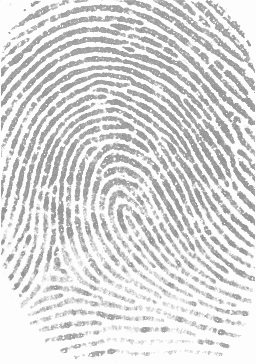

In [136]:
fingerprint1 = cv.imread('/content/socofing/SOCOFing/Altered/Altered-Easy/100__M_Left_index_finger_CR.BMP', cv.IMREAD_GRAYSCALE)
show(fingerprint)

In [137]:
fingerprint2 = cv.imread('/content/socofing/SOCOFing/Altered/Altered-Easy/100__M_Left_index_finger_CR.BMP')


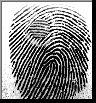

In [138]:
show(fingerprint2)

As we can see, in the altered image some portion is changed - but the minutae points are obtained from other spots

# Conclusion: 
In conclusion, we have hence created an Identification system to feed a fingerprint and obtain its match with accuracy.